This lesson was adapted from the end of [lesson 3](https://course.fast.ai/videos/?lesson=3) and beginning of [lesson 4](https://course.fast.ai/videos/?lesson=4) of the latest fast.ai Practical Deep Learning for Coders course.  We will cover all the material you need here in this notebook, so no need to have taken the Deep Learning course.  Even if you have taken the DL class, we will go slower and get into more detail here!

# Transfer Learning for Natural Language Modeling
### Contructing a Language Model and a Sentiment Classifier for IMDB movie reviews

Transfer learning has been widely used with great success in computer vision for several years, but only in the last year or so has it been successfully applied to NLP (beginning with ULMFit, which we will use here, which was built upon by BERT and GPT-2).

As Sebastian Ruder wrote in [The Gradient](https://thegradient.pub/) last summer, [NLP's ImageNet moment has arrived](https://thegradient.pub/nlp-imagenet/).

We will first build a language model for IMDB movie reviews.  Next we will build a sentiment classifier, which will predict whether a review is negative or positive, based on its text. For both of these tasks, we will use **transfer learning**. Starting with the pre-trained weights from the `wikitext-103` language model, we will tune these weights to specialize to the language of `IMDb` movie reviews. 

## Language Models

Language modeling can be a fun creative form. Research scientist [Janelle Shane blogs](https://aiweirdness.com/) & [tweets](https://twitter.com/JanelleCShane) about her creative AI explorations, which often involve text.  For instance, see her:

- [Why did the neural network cross the road?](https://aiweirdness.com/post/174691534037/why-did-the-neural-network-cross-the-road)
- [Try these neural network-generated recipes at your own risk.](https://aiweirdness.com/post/163878889437/try-these-neural-network-generated-recipes-at-your)
- [D&D character bios - now making slightly more sense](https://aiweirdness.com/post/183471928977/dd-character-bios-now-making-slightly-more)

## Using a GPU

You will need to have the fastai library installed for this lesson, and you will want to use a GPU to train your neural net.  If you don't have a GPU you can use in your computer (currently, only Nvidia GPUs are fully supported by the main deep learning libraries), no worries!  There are a number of cloud options you can consider:

[GPU Cloud Options](https://course.fast.ai/#using-a-gpu)

**Reminder: If you are using a cloud GPU, always be sure to shut it down when you are done!!! Otherwise, you could end up with an expensive bill!**

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.text import *
from scipy.spatial.distance import cosine as dist

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [3]:
# bs=192
bs=48
# bs=24

### Fix this line: should be `device(0)` instead of `device(2)`

In [5]:
#torch.cuda.set_device(2)
torch.cuda.set_device(0)

## 1. Prepare the IMDb data (on a sample)

First let's download the dataset we are going to study. The `IMDb` [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [5]:
URLs.IMDB_SAMPLE = 'https://skrisna-data-east-public.s3.amazonaws.com/imdb_sample'

In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv')]

In [7]:
path.as_uri

<bound method PurePath.as_uri of PosixPath('/root/.fastai/data/imdb_sample')>

It only contains one csv file, let's have a look at it.

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a `DataBunch` containing this data in one line of code:

### Load and preprocess the data and form a `databunch`
Add workaround for the bug in the `fastai Text API`

In [8]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data_lm = TextDataBunch.from_csv(path, 'texts.csv')
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 798 ms, sys: 251 ms, total: 1.05 s
Wall time: 3.6 s


By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [9]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

But the underlying data is all numbers

In [10]:
data_lm.train_ds[0][0].data[:10]

array([   2,    5,   44,   14,    9,  106, 3214,  946,   14,   13])

### Alternative approach: with the `data block API`

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

### Load and preprocess the data and form a `datablock`
Add workaround for the bug in the `fastai Text API`

In [11]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())        
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 928 ms, sys: 267 ms, total: 1.19 s
Wall time: 3.93 s


## 2. Transfer Learning <br>
### We are going to create an `IMDb` language model starting with the pretrained weights from the `wikitext-103` language model.

Now let's grab the full `IMDb` dataset for what follows.

In [6]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/data_save.pkl'),
 PosixPath('/root/.fastai/data/imdb/models'),
 PosixPath('/root/.fastai/data/imdb/imdb_textlist_class')]

In [7]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/pos'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

### More about WikiText-103

We will be using the `WikiText-103` dataset created by [Stephen Merity](https://smerity.com/) to pre-train a language model.

To quote [Stephen's post](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/):

*The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. The dataset is available under the Creative Commons Attribution-ShareAlike License.*

*Compared to the preprocessed version of Penn Treebank (PTB), WikiText-2 is over 2 times larger and WikiText-103 is over 110 times larger. The WikiText dataset also features a far larger vocabulary and retains the original case, punctuation and numbers - all of which are removed in PTB. As it is composed of full articles, the dataset is well suited for models that can take advantage of long term dependencies.*

[Download wikitext-103](https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-v1.zip). Unzip it into the `.fastai/data/` folder on your computer.

### 2A. Package the `IMDb` data into a language model `databunch`

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (this takes a few minutes).

We'll to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training; we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

Add a `try-except` wrapper as a workaround for the bug in the `fastai Text API`

In [6]:
%%time

# throws `BrokenProcessPool` Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           # notebook 3-logreg-nb-imbd used .split_by_folder instead of .filter_by_folder
            # and this took less time to run. Can we do the same here?
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1, seed=42))
           #We randomly split and keep 10% (10,000 reviews) for validation
            #.label_for_lm()           
           #We want to make a language model so we label accordingly
            #.databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 3.61 s, sys: 15.5 ms, total: 3.62 s
Wall time: 3.62 s


In [7]:
path

PosixPath('/root/.fastai/data/imdb')

#### I got faster results when I do the last two steps in a separate cell:

In [ ]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        #     the next step is the bottleneck
        data_lm = (data_lm.label_for_lm()           
           #We want to make a language model so we label accordingly
            .databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 1


failure count is 2


failure count is 3


In [17]:
len(data_lm.vocab.itos),len(data_lm.train_ds)

(60000, 90000)

In [18]:
data_lm.show_batch()

idx,text
0,"original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in"
1,"sign of xxmaj four "" feels like a xxmaj grand - xxmaj guignol - esque episode of "" xxmaj murder , xxmaj she xxmaj wrote "" ( right from the opening credits , that are of the worst possible kind : a montage of scenes from the movie ) as directed by xxmaj mel xxmaj brooks . xxmaj ian xxmaj richardson is a fine actor , and certainly looks the"
2,"the second tape . \n \n xxmaj the actors are to be commended for playing their roles well , despite a smarmy , overwrought script . xxmaj they are to be insulted , though , for accepting the roles in the first place . xxbos i 've seen all 3 now . i just ca n't believe how bad xxmaj naqoyqatsi is . xxmaj not in comparison to the"
3,"the opening scene "" xxmaj judge "" and xxmaj xxunk , the town 's museum operator . xxmaj she does n't trust any of them , and it 's true they do n't inspire any trust . xxmaj she 's rather crabby throughout the whole movie . xxmaj she wants to check her grandmother into a hospital . xxmaj the men in the town want her house , and the"
4,"in the process , the cult dude has a heart attack and it taken to the hospital . xxmaj he apparently dies , but it also seems like many of these hospital scenes are missing and a few of them appear much later in the film . xxmaj in other words , when you see the film , he appears to have possibly recovered -- only to hear later that"


#### Save the `databunch` for next time.

In [19]:
data_lm.save()

#### Load the saved data

In [20]:
?? load_data

In [9]:
data_lm = load_data(path, bs=bs)

### 2B. The **Transfer Learning** step.
#### This is where the magic happens!
#### The `AWD_LSTM` object contains the pretrained weights and the neural net architecture of the `wikitext-103` language model. These will be downloaded the first time you execute the following line, and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file). 

We import these into the `language_model_learner` object for our `IMDb` language model as follows:

In [22]:
AWD_LSTM

fastai.text.models.awd_lstm.AWD_LSTM

In [23]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

#### Get the `IMDb` language model `vocabulary`

In [24]:
vocab = data_lm.vocab

In [25]:
vocab.stoi["stingray"]

37232

In [26]:
vocab.itos[vocab.stoi["stingray"]]

'stingray'

In [27]:
vocab.itos[vocab.stoi["mobula"]]

'xxunk'

In [28]:
awd = learn_lm.model[0]

In [29]:
awd

AWD_LSTM(
  (encoder): Embedding(60000, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(60000, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

#### Get the `IMDb` language model `encoder`. Recall that the `encoder` translates tokens into numerical vectors in the space defined by the `IMDb` vocabulary.

In [30]:
enc = learn_lm.model[0].encoder

In [31]:
enc.weight.size()

torch.Size([60000, 400])

#### Difference in vocabulary between IMDB and Wikipedia language models

We are going to load `wiki_itos` (the index-to-string list) from the `wikitext 103` language model.  We will compare the vocabularies of `wikitext-103` and `IMDB`.  It is to be expected that the two sets have some different vocabulary words, and that is no problem for transfer learning!

In [32]:
#wiki_itos = pickle.load(open(Config().model_path()/'wt103-1/itos_wt103.pkl', 'rb'))
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

In [33]:
wiki_itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [34]:
len(wiki_itos)

60000

In [35]:
len(vocab.itos)

60000

In [36]:
i, unks = 0, []
while len(unks) < 50:
    if data_lm.vocab.itos[i] not in wiki_itos: unks.append((i,data_lm.vocab.itos[i]))
    i += 1

In [37]:
wiki_words = set(wiki_itos)

In [38]:
imdb_words = set(vocab.itos)

In [39]:
wiki_not_imbdb = wiki_words.difference(imdb_words)

In [40]:
imdb_not_wiki = imdb_words.difference(wiki_words)

In [41]:
len(wiki_not_imbdb), len(imdb_not_wiki)

(24226, 24226)

In [42]:
wiki_not_imdb_list = []

for i in range(100):
    word = wiki_not_imbdb.pop()
    wiki_not_imdb_list.append(word)
    wiki_not_imbdb.add(word)

In [43]:
wiki_not_imdb_list[:15]

['osijek',
 '361',
 'mediators',
 'periodicity',
 'æsir',
 'nuckelavee',
 'birdwatching',
 'i-96',
 'kristiania',
 'starscream',
 'avonmouth',
 'marlinspike',
 'nymphe',
 'thơ',
 'enna']

In [44]:
imdb_not_wiki_list = []

for i in range(100):
    word = imdb_not_wiki.pop()
    imdb_not_wiki_list.append(word)
    imdb_not_wiki.add(word)

In [45]:
imdb_not_wiki_list[:15]

['pollifax',
 'energizer',
 'ffviii',
 'bratt',
 'noqreh',
 'norinaga',
 'hsiao',
 'feasted',
 'bullwhip',
 'deven',
 'booger',
 'ambitiously',
 'unibrow',
 'daughter-',
 'netforce']

All words that appear in the `IMDB` vocab, but not the `wikitext-103` vocab, will be initialized to the same random vector in a model.  As the model trains, we will learn their weights.

In [46]:
vocab.stoi["modernisation"]

0

In [47]:
"modernisation" in wiki_words

True

In [48]:
vocab.stoi["30-something"]

25292

In [49]:
"30-something" in wiki_words, "30-something" in imdb_words

(False, True)

In [50]:
vocab.stoi["linklater"]

16250

In [51]:
"linklater" in wiki_words, "linklater" in imdb_words

(False, True)

In [52]:
"house" in wiki_words, "house" in imdb_words

(True, True)

In [53]:
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), 
            enc.weight[vocab.stoi["linklater"], :].cpu().detach().numpy())

True

In [54]:
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), 
            enc.weight[vocab.stoi["house"], :].cpu().detach().numpy())

False

In [55]:
new_word_vec = enc.weight[vocab.stoi["linklater"], :]

#### Generating fake movie review-like text with the **untrained** `IMDb` language model

In [56]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [57]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is blue , yellow , and yellow . The blue and grey sky is also the symbol of the sky . The sky , light , and dark sky are heavily coloured . The sky is composed of
The color of the sky is a dark dark brown and the air should be white or blue . The color of the sky is a dark yellow and yellow from the sky . The air is pale and dark , but the skies


In [58]:
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

In [59]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie episode for workers who were seductive and convicted for looting , and the Windsor Palace Police Department was hurt . The crime scene had a
I hated this movie for that reason , it was never released , but it was included in the 2003 film The Great American Tragedy . The film 's


In [60]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie as one of the most popular films of the year . This is one of the most controversial films of this era . It was used in films
I hated this movie by James Bond . In his book Bad Reality , Michael Moore , Steve Smith and Daniel Craig stated


In [61]:
doc(LanguageLearner.predict)

Lowering the `temperature` will make the texts less randomized.

In [62]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he was a fan of the Beatles . He said that he was " very proud " of the film ,
I hated this movie by James Cameron , Jr . , The Lord of the Rings , and The Lord of the Rings :


In [63]:
doc(LanguageLearner.predict)

In [64]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said that he was " a little bit more interested in the idea of a movie than a movie . "
I hated this movie by John Lennon , and he said , " i ' m not sure what i ' m doing . It 's a bad thing . "


### 2C. Training (fine-tuning) the `IMDb` language model
#### Starting with the `wikitext-103` pretrained weights, we'll fine-tune the model to "learn" the structure in the "language" of IMDb movie reviews.

#### Choose an appropriate learning rate.

In [65]:
learn_lm.data = data_lm

In [66]:
learn_lm.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


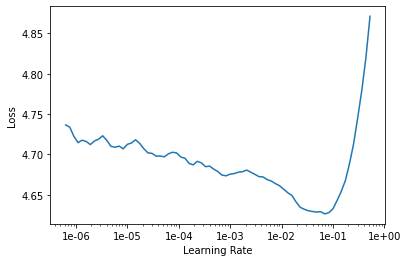

In [67]:
learn_lm.recorder.plot(skip_end=15)

In [68]:
lr = 1e-3
lr *= bs/48

#### Use the mixed-precision option, if you have it, otherwise omit this step

In [69]:
learn_lm.to_fp16()

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very hi

#### The first step in fine-tuning is to train only the last layer of the model. 
This takes about a half-hour on an NVIDIA RTX-2070 GPU

In [70]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.162468,3.714455,0.214286,27:25


Since this is relatively slow to train, we will save our weights:

In [76]:
learn_lm.save('fit_1')

In [77]:
learn_lm.load('fit_1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very hi

#### To complete the fine-tuning, we unfreeze all the weights and retrain
Adopting the `wikitext-103` weights as initial values, our neural network will adjust them via optimization, finding new values that are specialized to the "language" of `IMDb` movie reviews.

In [78]:
learn_lm.unfreeze()

Fine tuning the model takes ~30 minutes per epoch on an NVIDIA RTX-2070 GPU, with bs=48<br>
Note the relatively low value of accuracy, which did not improve significantly beyond `epoch 4`.

In [79]:
learn_lm.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.750044,3.241246,0.300000,31:10


#### Save the fine-tuned **language model** and the **encoder**
We have to save not just the `fine-tuned` **IMDb language model** but also its **encoder**. The **language model** is the part that tries to guess the next word. The **encoder** is the part that's responsible for creating and updating the hidden state. 

In the next part we will build a **sentiment classifier** for the IMDb movie reviews. To do this we will need the **encoder** from the **IMDb language model** that we built.

In [80]:
learn_lm.save('fine_tuned')

In [81]:
learn_lm.save_encoder('fine_tuned_enc')

#### Load the saved **model** and its **encoder**

In [82]:
learn_lm.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (90000 items)
x: LMTextList
xxbos i did n't know what to expect when i started watching this movie , by the end of it i was pulling my hairs out . xxmaj this was one of the most pathetic movies of this year ... in fact , in the last ten years . xxmaj david xxmaj dhawan should just give up his career as a director . i am yet to come across one original script that xxmaj david xxmaj dhawan has worked on . xxmaj this one was a complete bit y bit rip off xxmaj hitch . i have nothing against remakes as such , but this one is just so lousy that it makes you even hate the original one ( which was pretty decent ) . i fail to understand what actors like xxmaj salman and xxmaj govinda saw in this script . i read somewhere , that this was supposed to be xxmaj govinda 's comeback vehicle . xxmaj if that s true , then only xxmaj god can save his career . xxmaj salman just overacted to the hilt . xxmaj govinda who i think is an actor of very hi

Now that we've trained our model, different representations have been learned for the words that were in `IMDb` but not `wikitext-103` (remember that at the beginning we had initialized them all to the same thing):

In [83]:
enc = learn_lm.model[0].encoder

In [86]:
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), 
            enc.weight[vocab.stoi["linklater"], :].cpu().detach().numpy())

False

In [88]:
np.allclose(enc.weight[vocab.stoi["30-something"], :].cpu().detach().numpy(), new_word_vec.cpu().detach().numpy())

False

#### Generate movie review-like text, with the **fine-tuned** ` IMDb` language model
Compare these texts to the ones generated with the **untrained** `IMDb model` in part **2A**. Do they seem qualitatively better?

How good is our fine-tuned IMDb language model? Well let's try to see what it predicts when given a phrase that might appear in a movie review.

In [89]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [90]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because i liked Will Smith and Emmanuelle Paulson , but i love Jason Lee in Rambo , and The Affair of Murder is NOT the best of them .
i liked this movie because it was the first movie i read , and i am a huge fan of the original . The movie is good , but i think that Kelly was brave . It was not a good movie


In [91]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2

In [92]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was terrible . i do n't remember the word " WTF " in my book -- it was n't . It was so poorly edited and badly acted in
This movie was the worst of the worst movies i 've ever seen . i did n't expect much and was n't expecting anything much from it . If it was n't


In [93]:
TEXT = "I hated this movie"
N_WORDS = 40
N_SENTENCES = 2

In [94]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie . It , i do n't know , could have been a bit better . It had a lot of potential , but the characters did not make it that good . The story was not original
I hated this movie . It was so bad i was rooting for it . The only thing you thought was the idea of the movie was about a zombie attack on a drug addict , but it 's not .


#### Risks of language models

We will talk about ethical concerns raised by very accurate language models in lesson 7, but here are a few brief notes:

In reference to [OpenAI's GPT-2](https://www.theverge.com/2019/2/14/18224704/ai-machine-learning-language-models-read-write-openai-gpt2): Jeremy Howard said, *I’ve been trying to warn people about this for a while. We have the technology to totally fill Twitter, email, and the web up with reasonable-sounding, context-appropriate prose, which would drown out all other speech and be impossible to filter.*

For a small example, consider when completely incorrect (but reasonable sounding) ML generated answers were [posted to StackOverflow](https://meta.stackoverflow.com/questions/384596/completely-incorrect-machine-learning-generated-answers?stw=2):

<img src="images/robot-overflow.png" alt="Roboflow" style="width: 80%"/>

<img src="images/husain-tweet.png" alt="Roboflow" style="width: 60%"/>

## 3. Building an `IMDb Sentiment Classifier`
#### We'll now use **transfer learning** to create a `classifier`, again starting from the pretrained weights of the `wikitext-103` language model.  We'll also need the `IMDb language model` **encoder** that we saved previously. 

### 3A. Load and preprocess the data, and form a `databunch`
Using fastai's flexible API, we will now create a different kind of `databunch` object, one that is suitable for a **classifier** rather than a for **language model** (as we did in **2A**). This time we'll keep the labels for the `IMDb` movie reviews data. 

Add the `try-except` wrapper workaround for the bug in the `fastai Text API`

Here the batch size is decreased from 48 to 8, to avoid a `CUDA out of memory error`; your hardware may be able to handle a larger batch, in which case training will likely be faster.

Again, this takes a bit of time.

In [10]:
bs=24

In [11]:
%%time

# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!
#    the progress bar has to complete three consecutive steps. Why three? 
#    fails nearly 100 times, and doesn't respond to interrupt
count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos']))
             #label them all with their folders
             #.databunch(bs=bs, num_workers=1))
        error = False
        print(f'failure count is {count}\n')   
        
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')

failure count is 0

CPU times: user 15.6 s, sys: 5.41 s, total: 21 s
Wall time: 48.4 s


#### Form the preprocessed data into a `databunch`

In [12]:
data_clas = data_clas.databunch(bs=bs, num_workers=1)

#### Save the databunch (since it took so long to make) and load it

In [98]:
data_clas.save('imdb_textlist_class')

In [9]:
bs = 24

In [10]:
data_clas = load_data(path, 'imdb_textlist_class', bs=bs, num_workers=1)

In [21]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
xxbos * * * xxup spoilers * * * * * * xxup spoilers * * * xxmaj continued ... \n \n xxmaj from here on in the whole movie collapses in on itself . xxmaj first we meet a rogue program with the indication we 're gon na get ghosts and vampires and werewolves and the like . xxmaj we get a guy with a retarded accent talking,neg
"xxbos 8 xxmaj simple xxmaj rules for xxmaj dating xxmaj my xxmaj teenage xxmaj daughter had an auspicious start . xxmaj the supremely - talented xxmaj tom xxmaj shadyac was involved in the project . xxmaj this meant that the comedy would be nothing less of spectacular , and that 's exactly what happened : the show remains one of the freshest , funniest , wittiest shows made in a",pos
"xxbos xxmaj warning : xxmaj spoilers xxmaj galore ! \n \n xxmaj tim xxmaj burton remaking this sui generis movie is about as sensible as remaking xxmaj psycho - oh , that 's right , some idiot already did that - i rest my case . \n \n xxmaj movie opens with xxunk blundering a simulation , proving he 's not that smart from the outset . xxmaj",neg
"xxbos xxmaj office work , especially in this era of computers , multi - functional copy machines , e - mail , voice mail , snail mail and ` temps , ' is territory ripe with satirical possibilities , a vein previously tapped in such films as ` xxmaj clockwatchers ' and ` xxmaj office xxmaj space , ' and very successfully . xxmaj this latest addition to the temp",neg


### 3B. Create a model to **classify** the `IMDb` reviews, and load the **encoder** we saved before.
#### Freeze the weights for all but the last layer and find a good value for the learning rate. 

In [11]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3).to_fp16()
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

In [102]:
learn_c.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


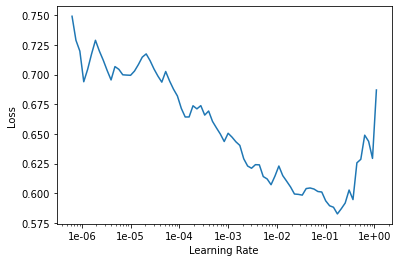

In [103]:
learn_c.recorder.plot()

### 3C. Training and fine-tuning the `IMDb sentiment classifier`

#### Train for one cycle, save intermediate result

In [ ]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time


In [17]:
learn_c.save('first')

In [18]:
learn_c.load('first');

#### Unfreeze last two layers and train for one cycle, save intermediate result.

In [106]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.247930,0.184820,0.935480,11:58


In [107]:
learn_c.save('2nd')

#### Unfreeze the last three layers, and train for one cycle, and save intermediate result.
At this point we've already beaten the 2017 (pre-transfer learning) state of the art!

In [108]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.246327,0.165970,0.942120,14:29


In [109]:
learn_c.save('3rd')

In [12]:
learn_c.load('3rd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (25000 items)
x: TextList
xxbos i was bored , around 10 pm , so i watched this movie . xxmaj and i could not stop laughing . xxmaj everything was so ridiculous . xxmaj the way the kids were acting like they were older than 11 just cracked me up . xxmaj one of the kids had a ring , that supposedly killed people after 3 or so years . xxmaj it gave me the impression that he wanted to be a gangster . 
 
  xxmaj it 's pretty hard to take little kids seriously , especially when it has to do with eating worms . xxmaj they act like everything is such a big deal , like if xxmaj billy ( the main character ) does n't eat the worms then the world will end . 
 
  xxmaj this is a good movie for little kids ( excluding the fact that a 5 year old says ' penis ' ) , but not for teens or adults who do n't want to waste their time .,xxbos xxmaj bill ( xxmaj buddy xxmaj rogers ) is sent to xxmaj new xxmaj york by his uncle ( xxmaj richard xxmaj tucker )

#### Unfreeze all the layers, train for two cycles, and save the result.

Note: at this step I encountered a `CUDA error: unspecified launch failure`. This is a known (and unsolved) problem with PyTorch when using an LSTM. https://github.com/pytorch/pytorch/issues/27837

Nothing to do but try again... and it worked on the second try.

In [32]:
learn_c.data = data_clas

In [35]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [46]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [47]:
dump_tensors(gpu_only=True)

Tensor: GPU pinned 1 × 1 × 1152
Tensor: GPU pinned 1 × 1 × 1152
Tensor: GPU pinned 1 × 1 × 1152
Tensor: GPU pinned 1 × 1 × 1152
Tensor: GPU pinned 1 × 1 × 400
Tensor: GPU pinned 1 × 1 × 400
Tensor: GPU pinned 1 × 18 × 1152
Tensor: GPU pinned 1 × 18 × 1152
Tensor: GPU pinned 1 × 18 × 400
Tensor: GPU pinned 1 × 18 × 1152
Tensor: GPU pinned 1 × 18 × 1152
Tensor: GPU pinned 1 × 18 × 400


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


Parameter: GPU pinned 60000 × 400
Parameter: GPU pinned 4608 × 1152
Parameter: GPU pinned 4608 × 1152
Parameter: GPU pinned 1600 × 400
Parameter: GPU pinned 4608 × 400
Parameter: GPU pinned 4608
Parameter: GPU pinned 4608
Parameter: GPU pinned 4608 × 1152
Parameter: GPU pinned 4608
Parameter: GPU pinned 4608
Parameter: GPU pinned 1600 × 1152
Parameter: GPU pinned 1600
Parameter: GPU pinned 1600
Parameter: GPU pinned 1200
Parameter: GPU pinned 1200
Tensor: GPU pinned 
Parameter: GPU pinned 50 × 1200
Parameter: GPU pinned 50
Parameter: GPU pinned 50
Parameter: GPU pinned 50
Tensor: GPU pinned 
Parameter: GPU pinned 2 × 50
Parameter: GPU pinned 2
Tensor: GPU pinned 1200
Tensor: GPU pinned 1200
Tensor: GPU pinned 50
Tensor: GPU pinned 50
Tensor: GPU pinned 60000 × 400
Tensor: GPU pinned 4608 × 1152
Tensor: GPU pinned 4608 × 400
Tensor: GPU pinned 4608
Tensor: GPU pinned 4608
Tensor: GPU pinned 4608 × 1152
Tensor: GPU pinned 4608 × 1152
Tensor: GPU pinned 4608
Tensor: GPU pinned 4608
Tensor

In [13]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.151772,0.148647,0.943080,06:53
1,0.103276,0.153657,0.943960,06:56


The state of the art for this dataset in 2017 was 94.1%, and we have crushed it!!!

#### Save the IMDb classifer model

In [12]:
learn_c.save('clas')

#### Let's look at a few examples, just to check that the classifier is working as we think it should. 
The three outputs of the model predition are the label (`pos` or `neg`) and the class probability estimates for `neg` and `pos`, which meausure the model's confidence in it's prediction. As we'd expect, the model is extremely confident that the first review is `pos` and quite confident that the second review is `neg`. So it passes the test with flying colors. 

In [13]:
learn_c.predict("I really loved that movie, it was awesome!")

C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category pos, tensor(1), tensor([0.0161, 0.9839]))

In [14]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\fastai\torch_core.py:83: UserWarning: Tensor is int32: upgrading to int64; for better performance use int64 input
  warn('Tensor is int32: upgrading to int64; for better performance use int64 input')


(Category neg, tensor(0), tensor([0.9698, 0.0302]))

#### Now that we've built the model, here is the part where you get to have some fun!! Take the model for a spin, try out your own examples!!

## Appendix: Language Model Zoo

fast.ai alumni have applied ULMFit to dozens of different languages, and have beat the SOTA in Thai, Polish, German, Indonesian, Hindi, & Malay.

They share tips and best practices in [this forum thread](https://forums.fast.ai/t/language-model-zoo-gorilla/14623) in case you are interested in getting involved!

<img src="images/language_model_zoo.png" alt="language model zoo" style="width: 80%"/>